<h1><center>Fashion_MNIST Dataset Introduction</center></h1>

### Contents
* [Introduction](#intro)
* [Setup](#second-bullet)
* [Fashion_MNIST](#dataset)
* [UMAP](#umap)
* [Machine Learning models:](#ml)
** [Random Forest](#ranfor)
** [Extra Tree](#extree)
** [XGBoost](#xgb)
** [Support Vector Machine](#svm)
* [Convolution Neural Network](#cnn)
* [Confusion Matrix](#conmat)
* [Run time comparison](#time)

### Introduction <a class="anchor" id="intro"></a>

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Here's an example how the data looks (each class takes three-rows):

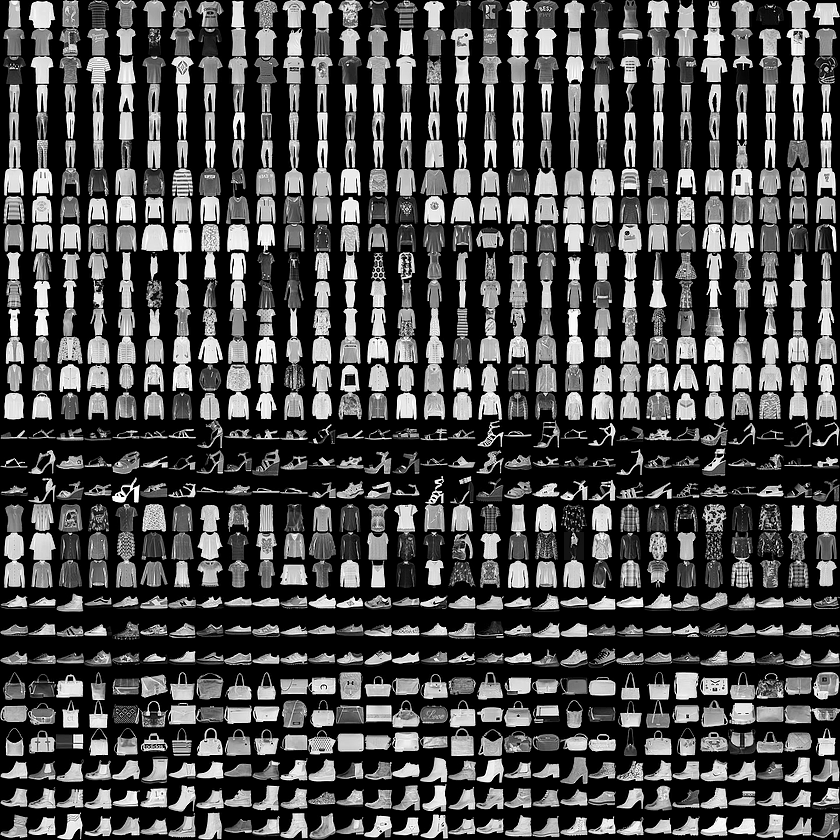

In [1]:
from IPython.display import Image
Image(filename='doc/img/fashion-mnist-sprite.png')

### Setup <a class="anchor" id="second-bullet"></a>
#### Python Imports

After importing the datasets we can visualise it using UMAP script. UMAP is a dimension reduction technique for data visualisation that is much faster than previously available techiniques. The Fashion MNIST embedded via UMAP shows the multidimensional space mapped into 2D with certain clusters closer or further apart. 

In [55]:
# Import libraries (alphabethical order now)
import importlib.util
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
import os
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as pyoff
import scipy.stats as stats
import seaborn as sns; sns.set()
import tensorflow as tf
import time
import umap
import warnings

from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn import svm
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

### Fashion_MNIST <a class="anchor" id="dataset"></a>

In [56]:
# Import Fashion MNIST data with one-hot encoding
dir_fashion = 'data/fashion/'
fashion_mnist = input_data.read_data_sets(dir_fashion, one_hot=True)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [4]:
# These are the labels attached to each image from the data set 
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

These are examples of 4 different images with corresponsing labels attached to them.

y = 3 (Dress)


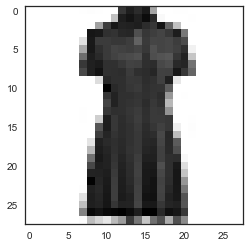

In [17]:
sns.set(style='white', rc={'figure.figsize':(6,4)})
# Get random images and associated label
sample_1 = fashion_mnist.train.images[47].reshape(28,28)
sample_label_1 = np.where(fashion_mnist.train.labels[47] == 1)[0][0]

# Show images and labels
print("y = {label_index} ({label})".format(label_index=sample_label_1, label=label_dict[sample_label_1]))
plt.imshow(sample_1, cmap='Greys')
plt.show()


Fashion_MNIST data is divided into train set and test set:

In [6]:
train = fashion_mnist.train
test = fashion_mnist.test

### UMAP <a class="anchor" id="umap"></a>

Visualise the train set only? Will this make a difference?

In [52]:
train_labels = []

for i in range (train.labels.shape[0]):
    classifier = np.where(fashion_mnist.train.labels[i] == 1)[0][0]
    train_labels.append(classifier)
test_labels= []
for i in range (test.labels.shape[0]):
    classifier = np.where(fashion_mnist.train.labels[i] == 1)[0][0]
    test_labels.append(classifier)

In [10]:
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

data = np.array(np.vstack([train.images, test.images]), dtype=np.float64) / 255.0
target = np.array(np.hstack([train_labels, test_labels]))

In [12]:
%%time
embedding = umap.UMAP(n_neighbors=5, metric='euclidean', random_state=42).fit_transform(data)

CPU times: user 1min 34s, sys: 7.17 s, total: 1min 41s
Wall time: 1min 28s


In [13]:
v = list(np.arange(10))

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

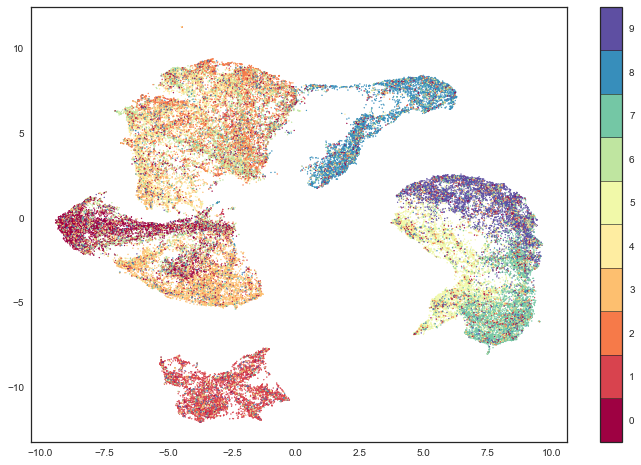

In [15]:
plt.scatter(embedding[:,0], embedding[:,1], c=target, cmap="Spectral", s=1)
#cbar = plt.colorbar(values=np.arange(10) , boundaries=np.arange(11)-0.5, ticks=np.arange(10), drawedges=True)
cbar = plt.colorbar(values=v, boundaries=np.arange(11)-0.5, ticks=np.arange(10), drawedges=True)
label_dict

### Comparison of Machine Learning Models <a class="anchor" id="ml"></a>

This classified dataset can be trained through various machine learning models and compared according their accuracy, running speed and deviation. 

In [7]:
# Load in the python file as a module
my_file = 'utils/mnist_reader.py'
spec = importlib.util.spec_from_file_location("mnist_reader", my_file)
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)

In [8]:
data_train = foo.load_mnist(dir_fashion, kind='train')
data_test = foo.load_mnist(dir_fashion, kind='t10k')

In [9]:
data_train_images = data_train[0] 
data_train_labels = data_train[1] 
data_test_images = data_test[0]
data_test_labels = data_test[1]

In [10]:
one = data_test_images[0]

In [11]:
one.shape 

(784,)

Initialise empty lists to store model names, accuracies and times 

In [12]:
models = []
accuracies = []
times = []

### Random Forest <a class="anchor" id="ranfor"></a>

This Decision Tree classifier is trained using different random subests of training set. To make a predicion, you obtain the predicion of all individual trees, then predict the class that gets the most votes. It is one of the most powerful Machine Learning algorithms available based on the "the wisdom of the crowd".

In [13]:
start = time.time()

rnd_clf = RandomForestClassifier(n_estimators=100, max_depth=50, criterion='entropy')
rnd_clf.fit(data_train_images , data_train_labels)

end = time.time()
time_rf= (end - start)

print (time_rf)
models.append('Random Forest')
times.append(round(time_rf, 2))

94.6350839138031


In [14]:
data_test_labels_predicted = rnd_clf.predict(data_test_images)
accu_rf = accuracy_score(data_test_labels_predicted, data_test_labels)
accuracies.append(accu_rf)

In [15]:
print(models, accuracies, times)

['Random Forest'] [0.8753] [94.64]


### Extra Tree <a class="anchor" id="extree"></a>

When growing a tree in a Random Forest at each node only a random subset of features is considered for splitting. It is possible to make trees even more random by using random tresholds for each feature rather than searching for the best possible threshold (this makes Extra Trees much faster).

In [341]:
start = time.time()

clf = ExtraTreesClassifier(n_estimators=50, max_depth=None, min_samples_split = 2, random_state=0)
clf.fit (data_train_images , data_train_labels)

end = time.time()
time_et=(end - start)

models.append('Extra Tree')
times.append(round (time_et, 2))

data_test_labels_predicted = clf.predict(data_test_images)
accu_et = accuracy_score(data_test_labels_predicted, data_test_labels)
accuracies.append(accu_et)

In [342]:
print(models, accuracies, times)

['Random Forest', 'Extra Tree', 'SVM', 'CNN model', 'XGBoost', 'Extra Tree', 'Random Forest', 'Random Forest', 'Extra Tree'] [0.8765, 0.8731, 0.8723, 0.888, 0.8582, 0.8731, 0.8756, 0.8773, 0.8731] [96.53, 24.56, 1111.21, 66.01, 2310.27, 22.98, 87.21, 93.71, 27.55]


Alternatively use cross validation function on Extra Trees where a training set is split into smaller training set and validation set, then trained against smaller training set and evaluated against validation set.  

In [205]:
label = clf.predict(new2)
print (label)

[8]


#Extra Tree 
start = time.time()

clf = ExtraTreesClassifier(n_estimators=50, max_depth=None, min_samples_split = 2, random_state=0)
scores = cross_val_score(clf, data_train_images , data_train_labels)
acc_et = scores.mean()
accuracies.append(acc_et)

end = time.time()
time_et=(end - start)

models.append('Extra Tree')
times.append(round (time_et, 2))

### XGBoost <a class="anchor" id="xgb"></a>

This model takes about 40 min to train. 

Gradient Boosting works by sequentailly adding predictors to an ensemble(multiple predictions from subsets), each one correcting its predecessor. This method tries to fit the new predictor to the residual errors made by previous predictor - focuses on "hard" cases.

In [49]:
start = time.time()

model = XGBClassifier()
model.fit(data_train_images, data_train_labels)

end = time.time()
time_xgb=(end - start)

models.append('XGBoost')
times.append(round (time_xgb, 2))

In [75]:
# make predictions for test data
data_test_labels_predicted = model.predict(data_test_images)
predictions = [round(value) for value in data_test_labels_predicted]
# evaluate predictions
accuracy = accuracy_score(data_test_labels, data_test_labels_predicted)
accuracies.append(accuracy)

In [76]:
print(models, accuracies, times)

['Random Forest', 'Extra Tree', 'SVM', 'CNN model', 'XGBoost'] [0.8765, 0.8731, 0.8723, 0.888, 0.8582] [96.53, 24.56, 1111.21, 66.01, 2310.27]


### Support Vector Machine <a class="anchor" id="ranfor"></a>

This takes about 20 min to run.

Support Vector Machine can be thought of as fitting the widest possible street (represented by the parallel dashed lines) between the classes. SVM is particularly well suited for classification of complex but small or medium sized datasets.

In [31]:
start = time.time()

# Create SVM classification object 
model = svm.SVC(kernel='poly', gamma=1) 
model.fit(data_train_images, data_train_labels)
model.score(data_train_images, data_train_labels)

end = time.time()
time_svm=(end - start)

models.append('SVM')
times.append(round (time_svm, 2))

In [32]:
#Predict Output
data_test_labels_predicted = model.predict(data_test_images)
accuracy = accuracy_score(data_test_labels, data_test_labels_predicted)
accuracies.append(accuracy)

In [34]:
print(models, accuracies, times)

['Random Forest', 'Extra Tree', 'SVM'] [0.8765, 0.8731, 0.8723] [96.53, 24.56, 1111.21]


Dropped Gradient Boosting Classifier - results were poor and running time high. 

### Convolutional Neural Networks <a class="anchor" id="cnn"></a>

In the Convolutional Neural Networks the most important building block is the convolutional layer: neurons in the first convolutional layer are not connected to every single pixel in the image, but only to pixels in the receptive fileds. The architecture allows the network to concentrate on the low-level features in the first hidden layer, then assemle them into higher-level features in the next one. 

CNN model in the seperate notebook as it has it build from basic layers, ReLU and pooling. http://localhost:8889/notebooks/Documents/GitHub/fashion-mnist-nn/CNN%20model.ipynb#

In [35]:
#appending values from the seperate notebook 

In [36]:
models.append('CNN model')
times.append(66.01)
accuracies.append(0.888)

In [37]:
print(models, accuracies, times)

['Random Forest', 'Extra Tree', 'SVM', 'CNN model'] [0.8765, 0.8731, 0.8723, 0.888] [96.53, 24.56, 1111.21, 66.01]


In [77]:
data_for_pretty_display = [item for item in zip(models, accuracies, times)]
pd.DataFrame(data_for_pretty_display, columns = ['Model','Accuracy','Time Taken (secs)'])

Model  Accuracy  Time Taken (secs)
0  Random Forest    0.8765              96.53
1     Extra Tree    0.8731              24.56
2            SVM    0.8723            1111.21
3      CNN model    0.8880              66.01
4        XGBoost    0.8582            2310.27

In [78]:
pd.DataFrame([models, accuracies, times])

0           1        2          3        4
0  Random Forest  Extra Tree      SVM  CNN model  XGBoost
1         0.8765      0.8731   0.8723      0.888   0.8582
2          96.53       24.56  1111.21      66.01  2310.27

## Confusion Matrix <a class="anchor" id="conmat"></a>

The confusion matrix - each row represents an actual class while the column represents a predicted class. 

In [38]:
matrix = confusion_matrix(data_test_labels, data_test_labels_predicted)

Rows are actual labels and columns are identfied labels


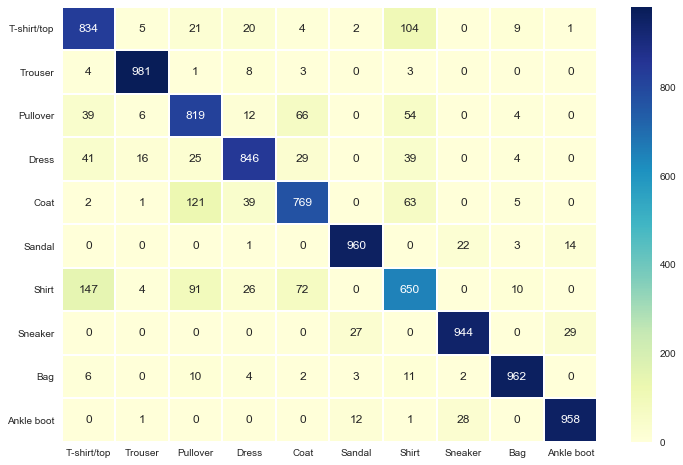

In [39]:
print ('Rows are actual labels and columns are identfied labels')
ax = sns.heatmap(matrix, cmap="YlGnBu", linewidths=1.0, annot=True, fmt="d", 
                 xticklabels= apparel_labels,
                 yticklabels= apparel_labels)

### Bionomial Error <a class="anchor" id="error"></a>

In the theory of probability and statistics, a Bernoulli trial (or binomial trial) is a random experiment with exactly two possible outcomes, "success" and "failure", in which the probability of success is the same every time the experiment is conducted. Binomial error is the standard deviation of the probability we calculate, which indicates how much lower or higher it can be.

In [40]:
pyoff.offline.init_notebook_mode()

In [41]:
def binomial_error(n, p):
    # This returns the standard deviation on the quantity p.
    # The arguments are in the order n first, p second,
    # to be consistent with scipy.stats.binom
    return np.sqrt((p*(1-p)/n))

In [42]:
binomial_error(10000, 0.8837)

0.0032058432588010282

In [67]:
def chart_by_segments_binominal_error(segments, n_throws_by_segment, n_wins_by_segment, 
                                      my_title, percent=True):

    percent_by_segment = [a/b for a, b in zip(n_wins_by_segment, n_throws_by_segment)]
    error_by_segment = [binomial_error(b, c) for b, c in zip(n_throws_by_segment, percent_by_segment)]
    my_text = [str(a)+' / '+str(b) for a, b in zip(n_wins_by_segment, n_throws_by_segment)]
    
    if(percent):
        percent_by_segment = [100*a for a in percent_by_segment]
        #percent_by_segment = ["{:.2%}".format(a) for a in percent_by_segment]
        error_by_segment = [100*a for a in error_by_segment]
    
    data = [
        go.Bar(
            x=segments,
            y=percent_by_segment,
            error_y=dict(
                array=error_by_segment,
                visible=True
            ),
            text = my_text
        )
    ]
    
    layout = go.Layout(
        title = my_title,
        yaxis = dict(title='Accuracies in percents')
    )
    
    fig = go.Figure(data=data, layout=layout)
    pyoff.iplot(fig, filename='percent-error-bar') 

In [68]:
a=10000

In [69]:
print(models, accuracies, times)

['Random Forest', 'Extra Tree', 'SVM', 'CNN model', 'XGBoost'] [0.8765, 0.8731, 0.8723, 0.888] [96.53, 24.56, 1111.21, 66.01, 2310.27]


In [79]:
n_wins_by_segment = [y *10000 for y in accuracies]
print (n_wins_by_segment)

[8765.0, 8731.0, 8723.0, 8880.0, 8582.0]


In [80]:
n_throws_by_segment = [a, a, a, a, a]
chart_by_segments_binominal_error(models, n_throws_by_segment, n_wins_by_segment, my_title='Models Accuarcy Comparison')

### Run time comparison <a class="anchor" id="time"></a>

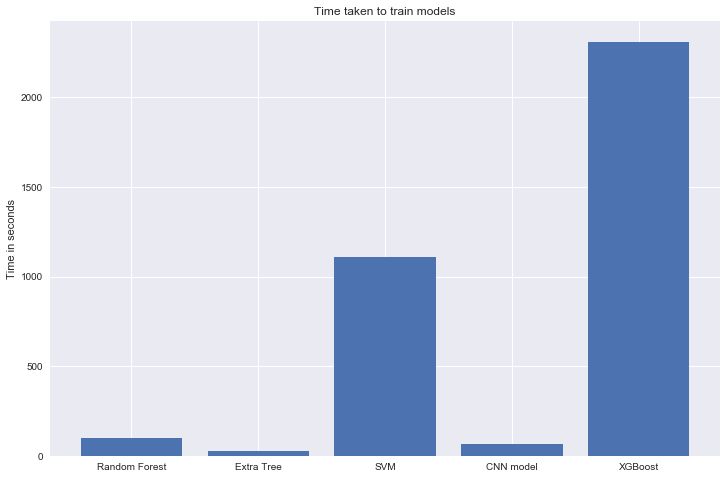

In [81]:
x = np.arange((len(times)))
plt.bar(x, times)
plt.title('Time taken to train models')
plt.ylabel('Time in seconds')
plt.xticks(x, models);

Labeling a downloaded image process 

In [24]:
from PIL import Image

In [21]:
import os

In [301]:
img = Image.open('images/rockstud-gladiator-sandals_000000004541737015.jpg').convert('L')

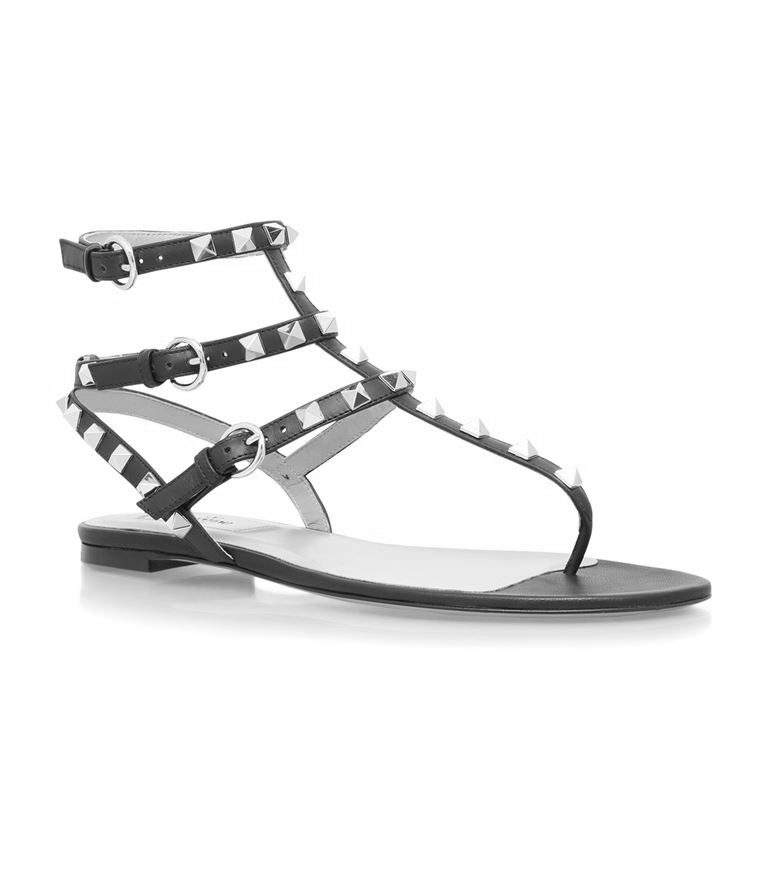

In [302]:
img

In [303]:
new = img.resize((28,28))

In [314]:
new

In [335]:
new2 = np.array([np.array(new).reshape((784,)),np.array(new).reshape((784,))] )

In [326]:
sample_1.shape

(28, 28)

In [336]:
new2.shape

(2, 784)

In [328]:
rnd_clf.predict(sample_1.reshape(1,784))

array([5], dtype=uint8)

In [337]:
label2 = rnd_clf.predict(new2)
print (label2)

[8 8]


In [221]:
#create an array to store images in 

In [329]:
type?

In [52]:
def process_images(directory, model):
    harrods_clothing = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            img = Image.open(directory+'/'+ file).convert('L')
            new = img.resize((28,28))
            plt.imshow(new)
            plt.show()
            new2 = 255-np.array(new).reshape((784,))
            harrods_clothing.append(new2)  
    return model.predict(harrods_clothing)


def predict_28x28_image_and_plot(img, model):
    
    plot_image(img.reshape(28,28))
    print(model.predict([img.reshape((784,))]))
    

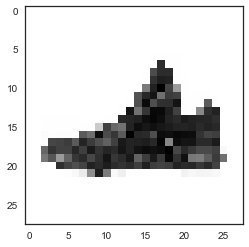

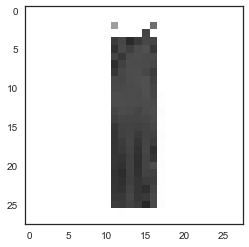

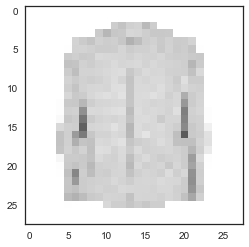

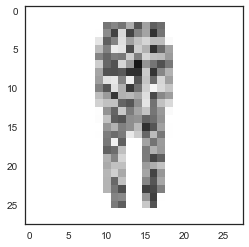

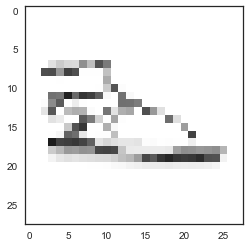

array([5, 3, 6, 1, 5], dtype=uint8)

In [53]:
process_images('images', rnd_clf)

In [35]:
def plot_image(img):
    plt.imshow(img, cmap='Greys')
    plt.show()

In [47]:
img = Image.open('images/rockstud-gladiator-sandals_000000004541737015.jpg').convert('L')
img = 255 - np.array(img)


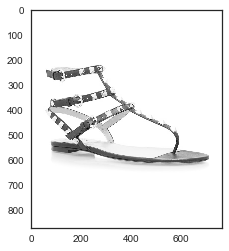

In [44]:
plot_image(255 - np.array(img))

In [30]:
sample_1 = data_test_images

In [372]:
label_dict

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}